<a href="https://colab.research.google.com/github/Linsonng/text2hologram/blob/main/text2hologram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title # Setup

#@markdown Run this code once. This step may take about 2 minutes.
#@markdown It encompasses package installations, device checks, and model loading.
#@markdown The output will be cleared upon completion.


clear_outputs = True # @param {type:"boolean"}
device_set = 'cuda'


# ---- Package Installation ----
!pip install text2hologram

# ---- Imports ----
from IPython.display import clear_output
import sys
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch

# Text2Hologram specific imports
from text2hologram.__main__ import parse_arguments
from text2hologram.settings import load_settings, update_settings
from text2hologram.device_setup import setup_device
from text2hologram.model import load_model
from text2hologram.image_generation import generate_images
from text2hologram.post_processing import process_depth_map, cgh
from text2hologram.super_resolution import super_resolve_image
from text2hologram.utils import display_images_from_directory, create_dirs, combine_rgb_images, display_images_from_directory, generate_image_names, display_selected_images
from text2hologram.color_recon import colored_recon

# ---- Setup and Model Loading ----
settings = {
    "general": {
        "device": device_set,
  }
}
# Set up the device
device = setup_device(settings)

# Load the model and necessary transforms
midas, pipe, transform = load_model(device)

# ---- Finalize Setup ----
if clear_outputs:
  clear_output()
print("Setup complete! You're now ready to create and display images.")


Setup complete! You're now ready to create and display images.


Creating images.


  0%|          | 0/40 [00:00<?, ?it/s]

Image saved as CGH_output//A ferrari sports car.jpg
Super-resolution is applied to create 4K images, requiring more memory. If crashing, use --super_reso=false to disable.
single-image-super-resolution-1032 already downloaded to model
Depth acquired.


Gradient Descent, loss:12232.6426
Outputs stored at CGH_output/


Gradient Descent, loss:13272.4082
Outputs stored at CGH_output/


Gradient Descent, loss:20361.3945
Outputs stored at CGH_output/


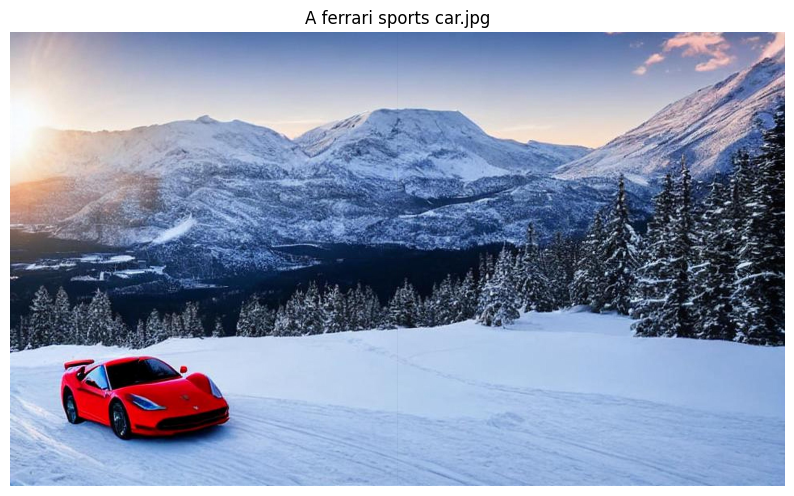

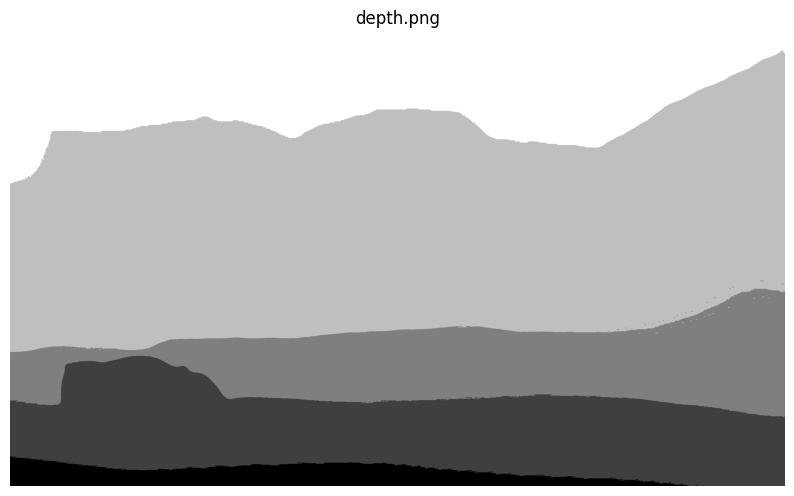

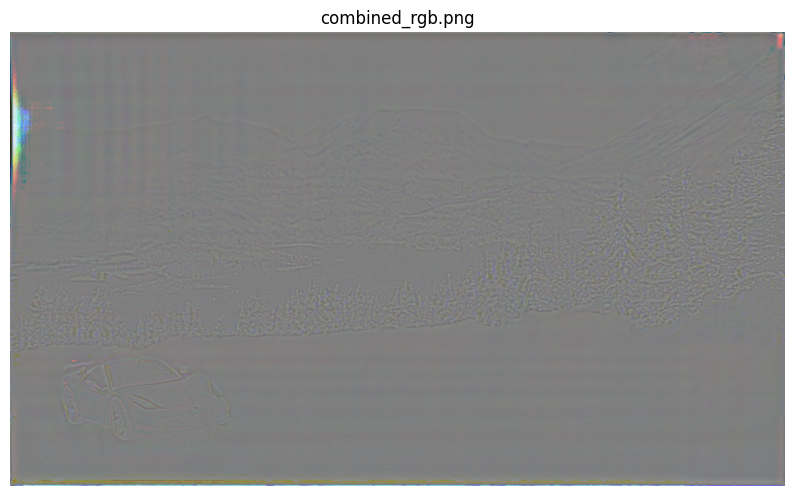

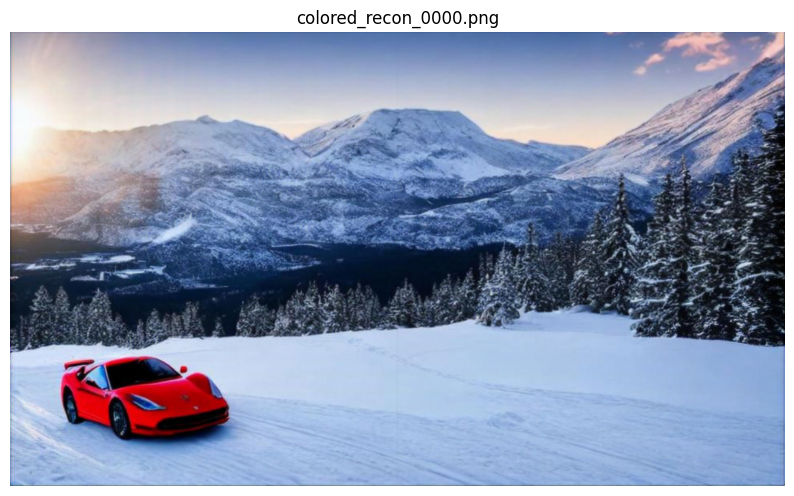

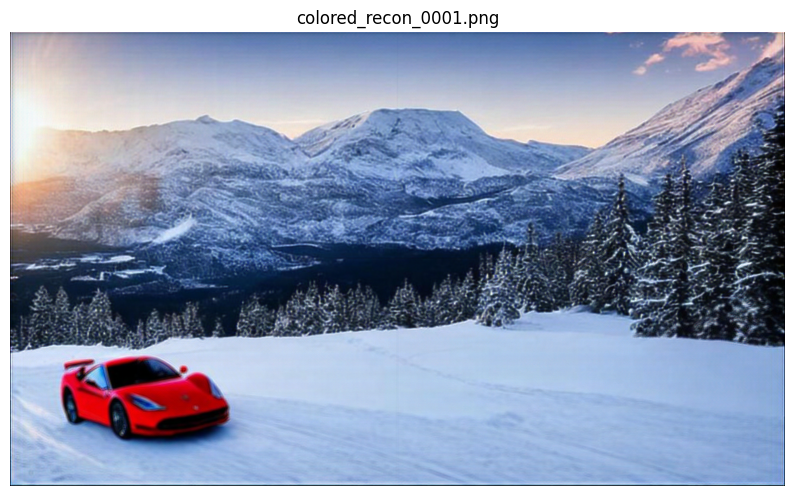

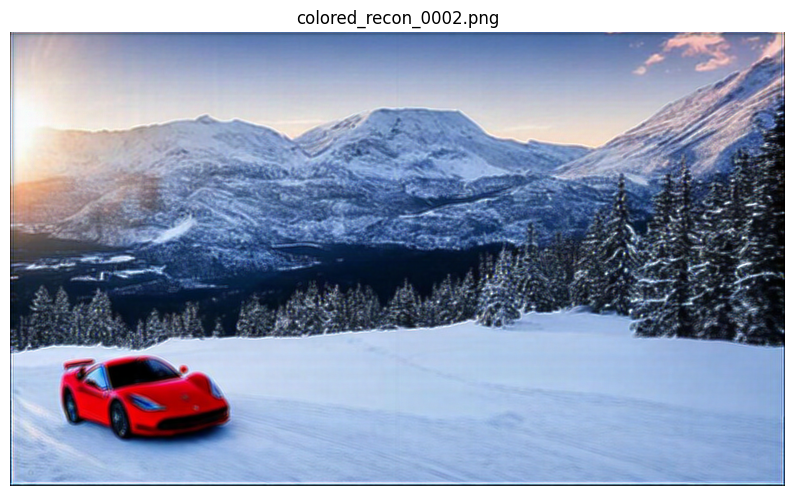

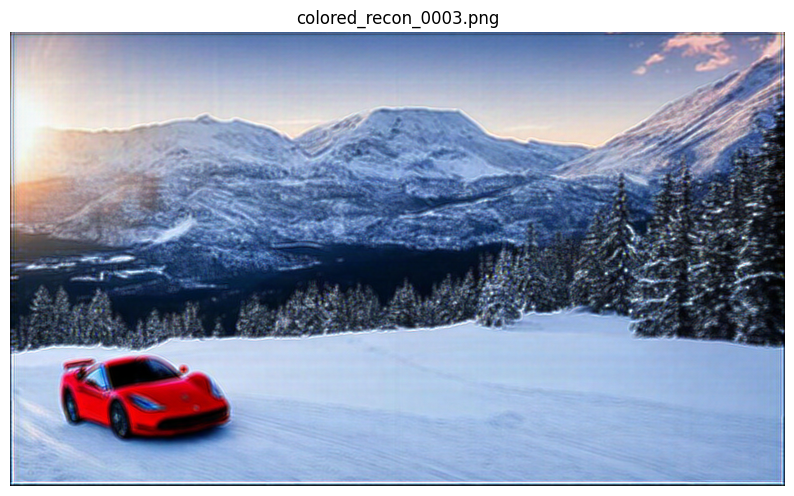

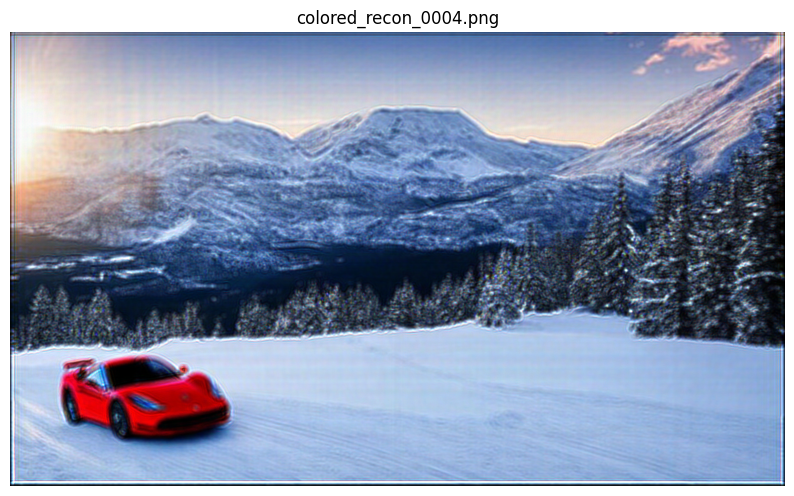

In [2]:
#@title # Text2hologram

# Get user input for the sentence to base the image creation on
prompt = "A ferrari sports car running on snowy mountain." #@param {type:"string"}
inference_steps = 40 # @param {type:"integer"}
# image_width = [600,1000] # @param ["[600,1000]", "[720,1200]", "[1200,2000]"] {type:"raw"}
output_directory = "CGH_output/" # @param {type:"string"}
display_generated_image = True # @param {type:"boolean"}
display_depth_planes = True # @param {type:"boolean"}
display_phase_only_hologram = True # @param {type:"boolean"}
display_colored_reconstruction = True # @param {type:"boolean"}

settings = {

    "general": {
        "device": device_set,
        "iterations": 200,
        "propagation type": "Bandlimited Angular Spectrum",
        "output directory": output_directory,
        "learning rate": 0.04,
        "hologram number": 1
    },
    "diffusion": {
        "inference_steps": 40,
        "resolution": [544, 960],
        "super_reso":'true'
    },
    "target": {
        "depth filename": "depthmap.jpg",
        "scheme": "defocus",
        "color channel": 1,
        "defocus blur size": 20,
        "blur ratio": 3,
        "number of planes": 5,
        "mask limits": [0.0, 1.0, 0.0, 1.0],
        "multiplier": 1.0,
        "weights": [1.0, 1.0, 1.0, 0.0]
    },
    "image": {
        "location": 0.0,
        "delta": 0.001,
        "zero mode distance": 0.15
    },
    "slm": {
        "model": "Jasper Display Educational 4k",
        "pixel pitch": 0.00000374,
        "resolution": [2400,4094]
    },
    "beam": {
        "wavelength": 0.000000518
    }
}


# Generate images
image_path, images = generate_images(pipe, prompt, settings, device)
torch.cuda.empty_cache()
if settings['diffusion']['super_reso']:
    print("Super-resolution is applied to create 4K images, requiring more memory. If crashing, use --super_reso=false to disable.")
    image_sr = super_resolve_image(image_path)
    settings['slm']['resolution'] = [2400,4094]

else:

    print("Super-resolution is off. Use --super_reso=true for 4K images. For memory issues, try on Colab:https://github.com/Linsonng/text2hologram/tree/main")
    image_sr = images[0]
    settings['slm']['resolution'] =  settings['diffusion']['resolution']
torch.cuda.empty_cache()

# Process the depth map
process_depth_map(midas, transform, np.array(image_sr), device, settings)

torch.cuda.empty_cache()

# Perform CGH
cgh(settings, image_path) # G
if os.path.exists(output_directory+'phase_0000.png'):
  os.rename(output_directory+'phase_0000.png', output_directory+'phase_G.png')

if display_colored_reconstruction:

  settings['target']['color channel'] = 0 # channel R
  settings['beam']['wavelength'] = 0.000000639 # wavelength of red light
  torch.cuda.empty_cache()
  cgh(settings, image_path)
  if os.path.exists(output_directory+'phase_0000.png'):
    os.rename(output_directory+'phase_0000.png', output_directory+'phase_R.png')


  settings['target']['color channel'] = 2 # channel B
  settings['beam']['wavelength'] = 0.000000473 # wavelength of blue light
  torch.cuda.empty_cache()
  cgh(settings, image_path)
  if os.path.exists(output_directory+'phase_0000.png'):
    os.rename(output_directory+'phase_0000.png', output_directory+'phase_B.png')

  torch.cuda.empty_cache()
  combine_rgb_images(output_directory+'phase_R.png', output_directory+'phase_G.png', output_directory+'phase_B.png', output_path=output_directory+'combined_rgb.png')
  colored_recon(output_directory,'combined_rgb.png',settings['target']["number of planes"])

image_name = prompt[0:20]


if display_generated_image:
  display_images_from_directory(output_directory, image_names=image_name+'.jpg', title=None, ext='.jpg', size=(10, 10))

if display_depth_planes:
  display_images_from_directory(output_directory, image_names='depth.png', title=None, ext='.png', size=(10, 10))

if display_phase_only_hologram:
  display_images_from_directory(output_directory, image_names='combined_rgb.png', title=None, ext='.png', size=(10, 10))

if display_colored_reconstruction:
  image_names = generate_image_names("colored_recon", settings['target']["number of planes"])
  display_images_from_directory(output_directory, image_names=image_names, title=None, ext='.png', size=(10, 10))

# Q&A Section

## Q1: I encountered a CUDA out-of-memory error. How can I fix it?
**Answer**: Encountering a CUDA out-of-memory error is not uncommon, especially when dealing with 4K images and deep learning algorithms. There are several approaches to tackle this issue:

1. **Empty Cache**: You can try executing `torch.cuda.empty_cache()` to clear the GPU cache and then restart the computation from the last successful checkpoint.
2. **Modular Execution**: Given that the code is highly modular, you can save intermediate results and start a new session, resuming from where the last session stopped.
3. **Upgrad Hardware**: A more straightforward but potentially costly solution is to switch to GPUs with higher memory capacity, such as the A100 GPU available on Colab.

## Q2: The process seems to be taking a long time. What's happening?
**Answer**: The initial setup, defined in `setup.py`, installs and configures the necessary libraries. Once you've entered your custom text prompt and initiated the run, most of the time is spent on image generation and hologram optimization. If you opt for color multi-plane reconstruction, the process will likely take more than double the time, approximately 2 minutes on an A100 GPU.

## Q3: Why am I seeing a 'noise' image?
**Answer**: What you're seeing is the phase of the hologram. In holography, the phase information encodes the depth of the 3D structure of the object being imaged. The pattern that appears like random noise or spots to the human eye is actually crucial for reconstructing the 3D image. Below the phase map, you'll find reconstructed images at various depths generated from that same phase information.

## Q4: Can I run this notebook on my own computer?
**Answer**: Absolutely. The source code is publicly available on PyPI, allowing you to run this notebook on any device with an internet connection. However, be cautious as some functions are computationally intensive and may require robust hardware.

## Q5: How many steps should I run for the diffusion model?
**Answer**: The number of steps for a text-to-image diffusion model is a trade-off between image quality and computational time. Generally, more steps lead to higher-quality images, but the improvement tends to plateau after a certain point. The computational time typically increases linearly with the number of steps. Based on experience, more than 30 inference steps usually yield stable and satisfactory results.

## Q6: What if I encounter an error not covered above?
**Answer**: For errors or issues not addressed in this FAQ, you can contact Pengze Li, who is responsible for this notebook. You can reach him at [linsonng@163.com](mailto:linsonng@163.com).
